#Introduction

In this project, our objective is to automatically detect whether a patient has a specific type of brain tumor or not. The input data is the MRI image from the patient's brain. Typically, detection of brain tumors is performed by radiologists or highly experienced neurosurgeons. However, in less developed areas where one may not find a specialist, machine learning methods may offer reliable solutions for pateints.

The data for this project can be obtained from the following link in Kaggle:

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/code

Since the data is in the form of images, spatial features play an important role to detect (classify) the output. Therefore, we employ convolutional neural nets (CNN) in this project. Let us briefly review the steps for this project:

1. Loading the data
2. Preprocessing the data
3. Design of the CNN model
4. Training the model
5. Validation and postprocessingthe data

# Data Loading


We download the MRI images using the Kaggle beta API. First, we create a token. Then, since I am using Google Colab, I upload it to my colab directory.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"masoudroudneshin","key":"55d3291547a7bb165eae56c9b92dbe44"}'}

In [ ]:
!pip install kaggle

Then, we setup the Kaggle API token.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Now, we download the dataset which is in zipped format.

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 75% 65.0M/86.8M [00:00<00:00, 129MB/s]
100% 86.8M/86.8M [00:00<00:00, 131MB/s]


Next, we unzip the data folder.

In [ ]:
!unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

Now, let's look at a couple of images. We also plot the countplot for the ttrain and the test set.

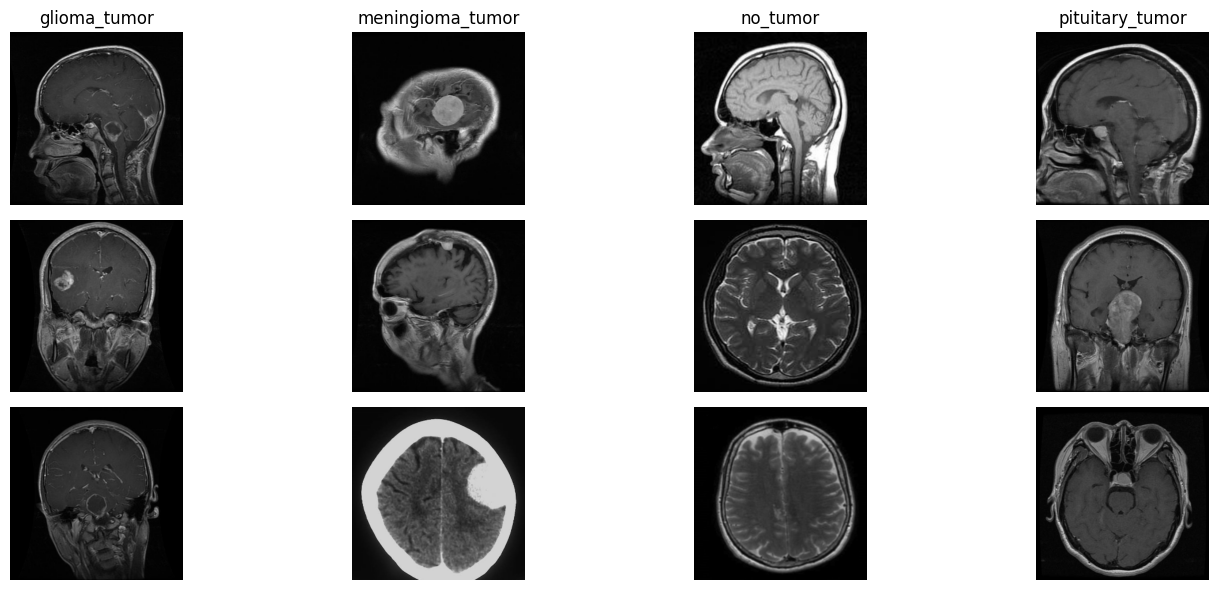

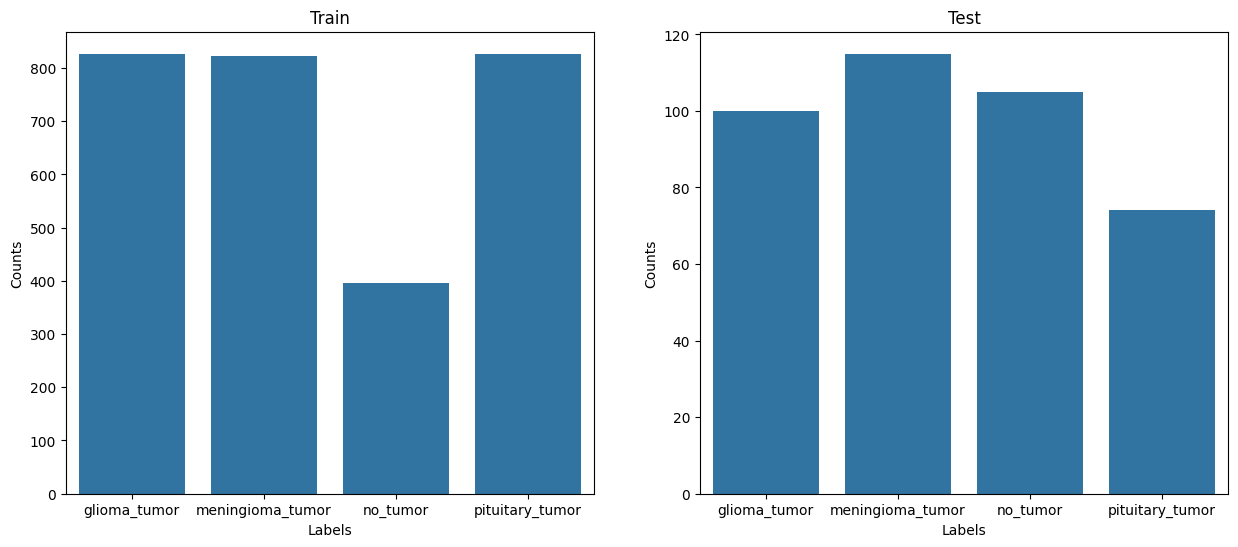

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns

# This function plots the first n images of each class
def show_images_of_class(train_dir,test_dir, img_size, n):
  class_names = sorted(os.listdir(train_dir))
  imgs_per_class = {class_name: [] for class_name in class_names}
  dict_count_train = {}
  dict_count_test = {}
  for class_name in class_names: # Loop over the class folder
    class_dir_train = os.path.join(train_dir, class_name)
    class_len = len(os.listdir(class_dir_train))
    dict_count_train[class_name] = class_len

    class_dir_test = os.path.join(test_dir, class_name)
    class_len = len(os.listdir(class_dir_test))
    dict_count_test[class_name] = class_len

    image_names = os.listdir(class_dir_train)[:n]
    for image_name in image_names: # Loop over the images in each class folder
      image_path = os.path.join(class_dir_train, image_name)
      img = cv2.imread(image_path)
      if img is not None:
        img = cv2.resize(img,img_size)
        imgs_per_class[class_name].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  fig, axes = plt.subplots(n, len(class_names), figsize = (15, 2*n))

  for i, class_name in enumerate(class_names):
    for j in range(n):
      if len(imgs_per_class[class_name]) > j:
                axes[j, i].imshow(imgs_per_class[class_name][j])
                axes[j, i].axis('off')
    axes[0, i].set_title(class_name)

  plt.tight_layout()
  plt.show()


  # Plot countplots

  df1 = pd.DataFrame(list(dict_count_train.items()), columns = ["Labels", "Counts"])
  df2 = pd.DataFrame(list(dict_count_test.items()), columns = ["Labels", "Counts"])


  figCount, axesCount = plt.subplots(1, 2, figsize = (15, 6))
  sns.barplot(x = "Labels", y = "Counts", data = df1, ax = axesCount[0])
  axesCount[0].set_title("Train")

  sns.barplot(x = "Labels", y = "Counts", data = df2, ax = axesCount[1])
  axesCount[1].set_title("Test")

# Run the function
train_dir = "/content/Training"
test_dir = "/content/Testing"
img_size = (300, 300)
n = 3
show_images_of_class(train_dir,test_dir,img_size, n)

# Preprocessing the data

In this step, we first convert all the training data to the same size (used later by the CNN) and convert them to np arrays. Given the relatively small size of the data, we also do some feature engineering and data augmentation to have richer training dataset.

We start by wrting a function that outputs the training, validation and the test set and their corresponding labels all as numpy arrays. Also, we take 20% of the original training data for validation.

In [ ]:
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(train_dir, test_dir, image_size):
    images_train_raw = []
    labels_train_raw = []
    images_test = []
    labels_test = []
    class_names = sorted(os.listdir(train_dir))
    class_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    # Load images and labels
    for class_name in class_names: # Loop over the classes
        class_dir_train = os.path.join(train_dir, class_name)
        class_dir_test = os.path.join(test_dir, class_name)
        # Training set preprocessing
        for img_name in os.listdir(class_dir_train): # Loop over the images in each class of the raw training data
            img_path = os.path.join(class_dir_train, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                images_train_raw.append(img)
                labels_train_raw.append(class_map[class_name])

        # Test set preprocessing
        for img_name in os.listdir(class_dir_test): # Loop over the images in each class of the raw training data
            img_path = os.path.join(class_dir_test, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                images_test.append(img)
                labels_test.append(class_map[class_name])

    # Convert to numpy arrays + divide by 255 to normalize
    X_train_raw = np.array(images_train_raw)/255
    y_train_raw = np.array(labels_train_raw)

    X_train, X_valid, y_train, y_valid = train_test_split(X_train_raw, y_train_raw,
                                                        test_size=0.2, random_state=42)

    X_test = np.array(images_test)/255
    y_test = np.array(labels_test)


    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test), labels_train_raw, labels_test

# Example usage
train_dir = '/content/Training'
test_dir = '/content/Testing'
image_size = (256, 256)  # Desired image size

(X_train, y_train), (X_valid, y_valid), (X_test, y_test), labels_train_raw, labels_test = load_and_preprocess_images(train_dir, test_dir, image_size)
# Check the shapes of the datasets
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_valid.shape)
print("Validation labels shape:", y_valid.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)


Training data shape: (2296, 256, 256, 3)
Training labels shape: (2296,)
Validation data shape: (574, 256, 256, 3)
Validation labels shape: (574,)
Testing data shape: (394, 256, 256, 3)
Testing labels shape: (394,)


Since the training data is scarse, we would like to stretch the training set by adding slightly altered versions of the original images.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Train_Data_Gen = ImageDataGenerator(rotation_range = 40, width_shift_range = 0.2,
                              height_shift_range = 0.2, shear_range = 0.2,
                              zoom_range = 0.2, horizontal_flip = True,
                              fill_mode = 'nearest')

Valid_Data_Gen = ImageDataGenerator()

train_generator = Train_Data_Gen.flow(X_train, y_train, batch_size = 32)
valid_generator = Valid_Data_Gen.flow(X_valid, y_valid, batch_size = 32)

# Design of the CNN

We first start by a relatively shallow CNN.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout, Input

model_1 = Sequential([Input(shape = (256,256,3)),
                    Conv2D(32 ,(3,3), activation = "relu", padding = "same"),
                    BatchNormalization(),
                    MaxPooling2D(),
                    Conv2D(64 ,(3,3), activation = "relu", padding = "same"),
                    BatchNormalization(),
                    MaxPooling2D(),
                    Conv2D(128 ,(3,3), activation = "relu", padding = "same"),
                    BatchNormalization(),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(64, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(4, activation = "softmax")])



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = '/content/drive/MyDrive/ColabNotebooks/Best_model.keras'
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=2, restore_best_weights=True, mode='max', min_delta=0)
model_checkpoint = ModelCheckpoint(filepath= checkpoint_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
reduce_Plateau = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, min_lr=0.0001, factor=0.2)

In [ ]:
model_1.compile(loss = "sparse_categorical_crossentropy", metrics = ["accuracy"],
              optimizer = "adam")
history = model_1.fit(
    train_generator,
    epochs= 40,
    batch_size = 32,
    validation_data = valid_generator,
    callbacks = [early_stop, model_checkpoint, reduce_Plateau]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.4014 - loss: 1.7626
Epoch 1: val_accuracy improved from -inf to 0.27178, saving model to /content/drive/MyDrive/ColabNotebooks/Best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4021 - loss: 1.7591 - val_accuracy: 0.2718 - val_loss: 5.8282 - learning_rate: 0.0010
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5321 - loss: 1.2017
Epoch 2: val_accuracy improved from 0.27178 to 0.50174, saving model to /content/drive/MyDrive/ColabNotebooks/Best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 397ms/step - accuracy: 0.5322 - loss: 1.2015 - val_accuracy: 0.5017 - val_loss: 2.2300 - learning_rate: 0.0010
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5547 - loss: 1.1424
Epoch 3: val_accuracy did not improve from 0.50174
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 381ms/step - accuracy: 0.5548 - loss: 1.1420 - val_accuracy: 0.2770 - val_loss: 3.1750 - learning_rate: 0.0010
Epoch 4/40
72/72 ━━━━━━━━━━

Let's plot the results for this model.

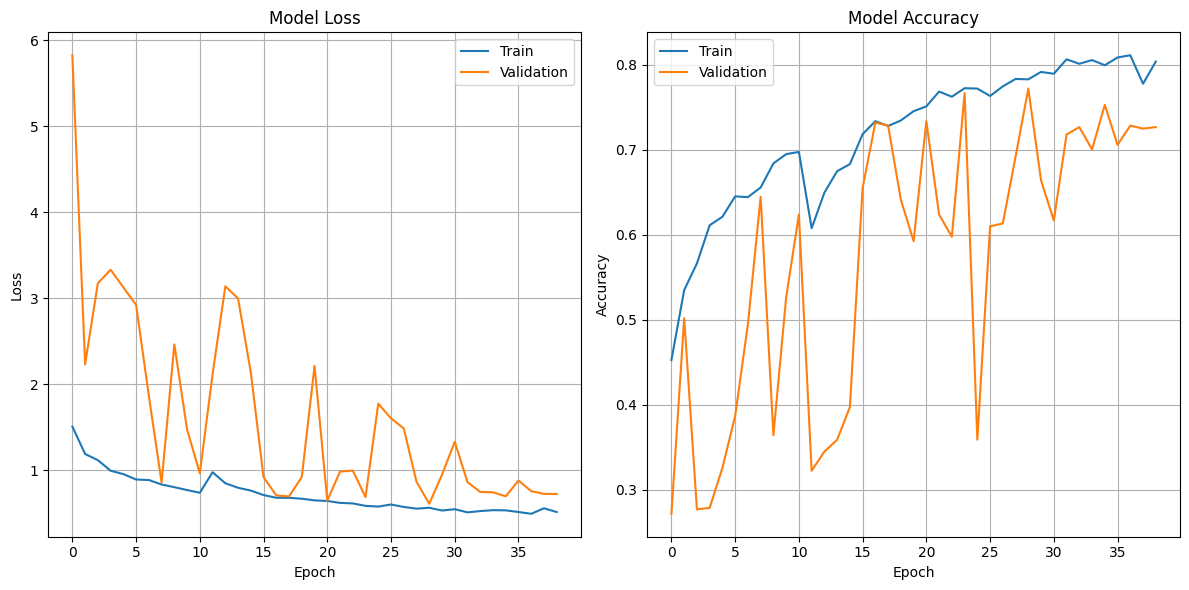

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)


plt.tight_layout()
plt.show()

Clearly, the model is underfitting the data. Therefore, we require a more complex model. One solution is to apply transfer-learning. We can design the model to have weights from a pre-trained CNN and then add or own units. For this purpose, we import 7 pre-trained neural nets as follows:

1. EfficientNetB1
2. EfficientNetB4
3. VGG16
4. VGG19
5. ResNet50
6. Xception
7. NASNetMobile

We build a function and assess the accuracy of each of these base models for 3 epochs. Then, we select the model with highest accuracy and continue the training.

In [ ]:
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB4, VGG16, VGG19, ResNet50, Xception, NASNetMobile

# Load the VGG16 model, excluding the top classification layers
base_model_EfficientNetB1 = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_EfficientNetB4 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_Xception = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_NASNetMobile = NASNetMobile(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_models = [base_model_EfficientNetB1, base_model_EfficientNetB4, base_model_VGG16, base_model_VGG19,
               base_model_ResNet50, base_model_Xception, base_model_NASNetMobile]

19993432/19993432 [==============================] - 0s 0us/step


We define the model as combination of a base model followed by our model as indicated in the following table

| Stage          | Layer Type      | Description                               |
|----------------|-----------------|-------------------------------------------|
| Stage 0        | Base Model          | |
| Stage 1        | Conv2D          | Feature Maps:32 &nbsp; Kernel Size:(3,3) |
| Stage 2        | BatchNormalization            |  |
| Stage 3        | MaxPooling2D    |  |
| Stage 4        | Conv2D          |   Feature Maps:64 &nbsp; Kernel Size:(3,3) |
| Stage 5        | BatchNormalization            | |
| Stage 6        | MaxPooling2D    |  |
| Stage 7        | Flatten         |  |
| Stage 8        | Dense (Fully Connected) | units: 32, activation: ReLu |
| Stage 9        | BatchNormalization         |  |
| Stage 10        | Dense (Fully Connected) | units: 4, activation: Softmax |




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout, Input


def build_model(base_model):
  for layer in base_model.layers:
    layer.trainable = False

  model = Sequential([Input((256,256,3)),
                      base_model,
                      Conv2D(32 ,(3,3), activation = "relu", padding = "same"),
                      BatchNormalization(),
                      MaxPooling2D(),
                      Conv2D(64 ,(3,3), activation = "relu", padding = "same"),
                      BatchNormalization(),
                      MaxPooling2D(),
                      # Conv2D(128 ,(3,3), activation = "relu", padding = "same"),
                      # BatchNormalization(),
                      # MaxPooling2D(),
                      Flatten(),
                      Dense(32, activation = "relu"),
                      BatchNormalization(),
                      Dense(4, activation = "softmax")])

  return model

Let's run the models and store their accuracy in the dictionary "accuracy_initial_dict".

In [ ]:
accuracy_initial_dict = {}
for base_model in base_models:
  model = build_model(base_model)

  model.compile(loss = "sparse_categorical_crossentropy", metrics = ["accuracy"],
                optimizer = "adam")

  history = model.fit(
    train_generator,
    epochs= 3,
    batch_size = 16,
    validation_data = valid_generator)

  accuracy_initial_dict[base_model] = history.history['accuracy']

Epoch 1/3
72/72 [==============================] - 69s 813ms/step - loss: 1.4188 - accuracy: 0.2909 - val_loss: 2.2813 - val_accuracy: 0.3118
Epoch 2/3
72/72 [==============================] - 56s 774ms/step - loss: 1.3561 - accuracy: 0.3088 - val_loss: 1.6410 - val_accuracy: 0.3118
Epoch 3/3
72/72 [==============================] - 57s 788ms/step - loss: 1.3496 - accuracy: 0.2922 - val_loss: 1.3538 - val_accuracy: 0.3171
Epoch 1/3
72/72 [==============================] - 119s 1s/step - loss: 1.3859 - accuracy: 0.3049 - val_loss: 4.8493 - val_accuracy: 0.3118
Epoch 2/3
72/72 [==============================] - 102s 1s/step - loss: 1.3078 - accuracy: 0.3253 - val_loss: 2.6964 - val_accuracy: 0.3136
Epoch 3/3
72/72 [==============================] - 103s 1s/step - loss: 1.3047 - accuracy: 0.3476 - val_loss: 2.5547 - val_accuracy: 0.3171
Epoch 1/3
72/72 [==============================] - 69s 933ms/step - loss: 1.0277 - accuracy: 0.5858 - val_loss: 0.8984 - val_accuracy: 0.5505
Epoch 2/3
72

In [ ]:
# New keys
new_keys = ['EfficientNetB1', 'EfficientNetB4', 'VGG16', 'VGG19',
               'ResNet50', 'Xception','NASNetMobile']


# Create a new dictionary with updated keys
new_dict = {new_keys[i]: value for i, (key, value) in enumerate(accuracy_initial_dict.items())}

df_base_models = pd.DataFrame(new_dict)
print(df_base_models)


   base_model_EfficientNetB1  base_model_EfficientNetB4  base_model_VGG16  \
0                   0.270470                   0.309233          0.499564   
1                   0.280052                   0.355401          0.713850   
2                   0.284843                   0.330575          0.756533   

   base_model_VGG19  base_model_ResNet50  base_model_Xception  \
0          0.436411             0.377613             0.596254   
1          0.610192             0.473868             0.750871   
2          0.712979             0.523519             0.787456   

   base_model_NASNetMobile  
0                 0.558798  
1                 0.723868  
2                 0.761324  


We observe that the model with Xception and NASNetMobile have the highest accuracy and can be selected as the base model performs best. We continue with Xception and train our CNN.

In [ ]:
model_Xception = build_model(base_model_Xception)
model_Xception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 32)          589856    
                                                                 
 batch_normalization_8 (Bat  (None, 8, 8, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 batch_normalization_9 (Bat  (None, 4, 4, 64)         

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = '/content/drive/MyDrive/ColabNotebooks/Best_Xception.keras'
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=2, restore_best_weights=True, mode='max', min_delta=0)
model_checkpoint = ModelCheckpoint(filepath= checkpoint_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
reduce_Plateau = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, min_lr=0.0001, factor=0.2)

model_Xception.compile(loss = "sparse_categorical_crossentropy", metrics = ["accuracy"],
              optimizer = "adam")

In [ ]:
history = model_Xception.fit(
  train_generator,
  epochs= 100,
  batch_size = 16,
  validation_data = valid_generator,
  callbacks = [early_stop, model_checkpoint, reduce_Plateau])

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 0.9306 - accuracy: 0.6372
Epoch 1: val_accuracy improved from -inf to 0.72648, saving model to /content/drive/MyDrive/ColabNotebooks/Best_Xception.keras
72/72 [==============================] - 62s 814ms/step - loss: 0.9306 - accuracy: 0.6372 - val_loss: 0.7243 - val_accuracy: 0.7265 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.7805
Epoch 2: val_accuracy did not improve from 0.72648
72/72 [==============================] - 56s 776ms/step - loss: 0.5984 - accuracy: 0.7805 - val_loss: 0.7256 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.8127
Epoch 3: val_accuracy improved from 0.72648 to 0.80662, saving model to /content/drive/MyDrive/ColabNotebooks/Best_Xception.keras
72/72 [==============================] - 57s 794ms/step - loss: 0.5022 - accuracy: 0.8127 - val_loss: 0.5271 - val_ac

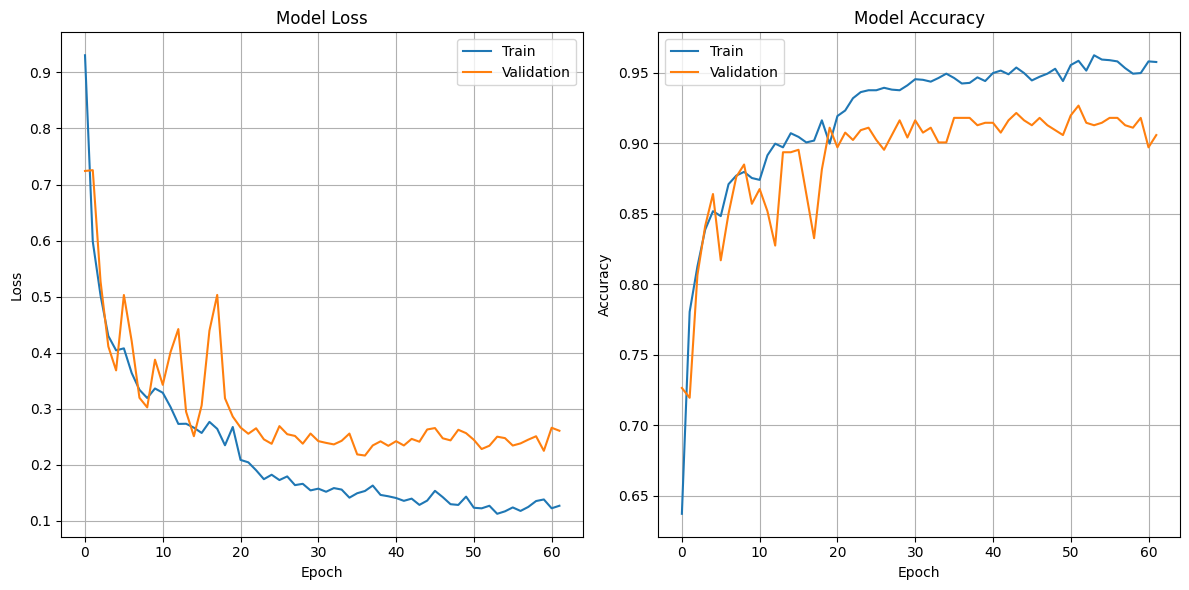

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)


plt.tight_layout()
plt.show()

# Model Evaluation

We first assess the model accuracy on test data. Then, we discuss confusion matrix and different performance metrics of our model.

In [ ]:
test_loss, test_accuracy = model_Xception.evaluate(X_test, y_test)
print(f"Test accuracy is:{test_accuracy}")

13/13 [==============================] - 7s 539ms/step - loss: 1.2410 - accuracy: 0.7513
Test accuracy is:0.7512690424919128


13/13 [==============================] - 7s 537ms/step


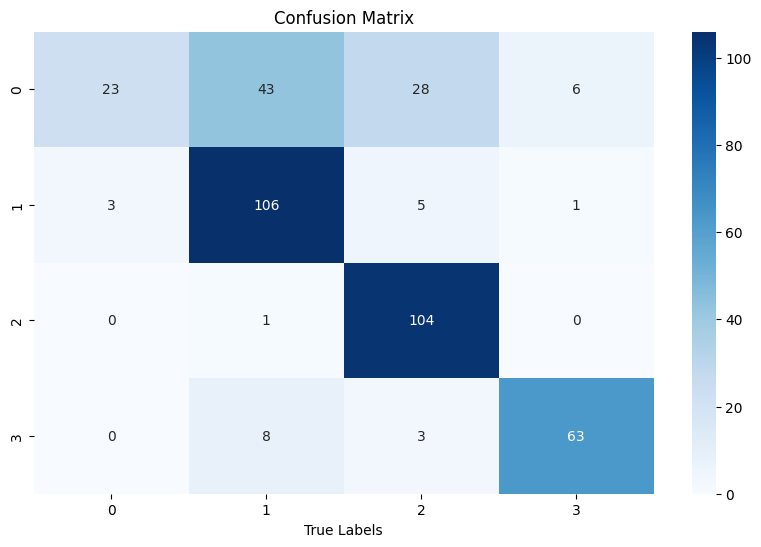

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model_Xception.predict(X_test)
predicted_classes = np.argmax(predictions, axis = 1)
# true_classes = np.argmax(y_test, axis = 1)

cf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot = True, fmt = "d", cmap = "Blues")
plt.xlabel("Predicted Labels")
plt.xlabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Comments for Model Improvement

We see some patterns of overfitting in the accuracy and loss plots. One solution may be to use a simpler model so that the model have better generalization. In adition, we observe an asymmetry in the confusion matrix, specifically, in the second class (meningioma_tumor). If we use feature engineering in such a way to balance the number of instances for each class,  